In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager


from examples.fracture import configs
from examples.fracture.model import PINN

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [3]:
cfg = configs.Config()
pinn = PINN(config=cfg)
ckpt = ocp.StandardCheckpointer()
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/baseline0_model400_6-epoch30000/model-30000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/baseline_model400_8-epoch50000-loading6/model-50000/")
state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/2025-06-08-10-27-08/model-3000/")
params = state["params"]

In [4]:
with open(f"{cfg.DATA_PATH}/force_disp.txt", "r") as f:
    lines = f.readlines()

def parse_line(line):
    line = line.strip().split("\t")
    line = [float(x) for x in line]
    return line
ref_force_disp = list(map(parse_line, lines))

# ref_force_disp = list(map(parse_line, lines))
# add 0, 0 at the beginning
ref_force_disp = [(0.0, 0.0)] + ref_force_disp
ref_force_disp = jnp.array(ref_force_disp)

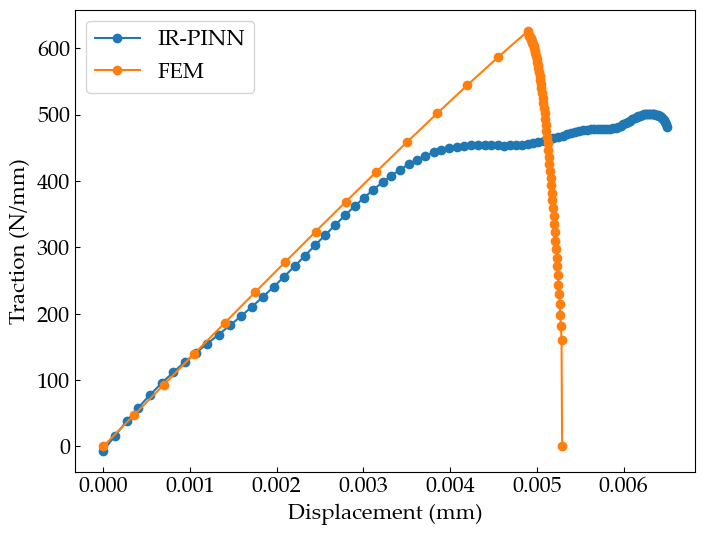

In [5]:
ts = jnp.linspace(0, 1, 101)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
xs = jnp.linspace(-0.5, 0.5, 100)
ys = jnp.ones_like(xs) * (-0.5)
top_mesh = jnp.stack([xs, ys], axis=1)
norm_vector = jnp.array([0, 1])

from jax.scipy import integrate

tractions = []
for idx, tic in enumerate(ts):
    t = jnp.ones_like(top_mesh[:, 0]) * tic
    t = t.reshape(-1, 1)
    # phi, disp = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, top_mesh, t)

    sigma = jax.lax.stop_gradient(vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params, top_mesh, t))

    traction_vectors = jnp.einsum('ijk,k->ij', sigma, norm_vector)
    traction_normal = traction_vectors[:, 1]
    total_traction = integrate.trapezoid(traction_normal, xs)
    tractions.append(total_traction)
    
tractions = jnp.array(tractions)
%matplotlib inline
loading = cfg.loading(ts)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loading, tractions, marker="o", label="IR-PINN")
ax.plot(ref_force_disp[:, 0], ref_force_disp[:, 1], label="FEM", marker="o",)
ax.set(
    xlabel="Displacement (mm)",
    ylabel="Traction (N/mm)",
    # ylim=(0, 700),
)
ax.legend()


[Text(0.5, 0, 'Displacement (mm)'), Text(0, 0.5, 'Traction (N/mm)')]

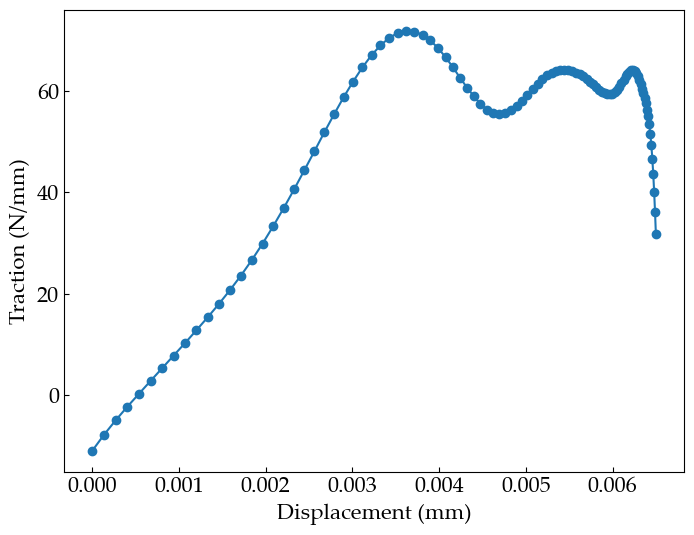

In [6]:

ts = jnp.linspace(0, 1, 101)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
ys = jnp.linspace(-0.5, 0.5, 1000)
xs = jnp.ones_like(ys) * (0.5)
top_mesh = jnp.stack([xs, ys], axis=1)
norm_vector = jnp.array([1, 0])

tractions = []
for idx, tic in enumerate(ts):
    t = jnp.ones_like(top_mesh[:, 0]) * tic
    t = t.reshape(-1, 1)
    # phi, disp = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, top_mesh, t)
    sigma = jax.lax.stop_gradient(vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params, top_mesh, t))

    phi = jax.lax.stop_gradient(vmap(
        lambda params, x, t: pinn.net_u(params, x, t)[0], in_axes=(None, 0, 0)
    )(params, top_mesh, t)).squeeze()

    traction_vectors = jnp.einsum('ijk,k->ij', sigma, norm_vector)
    traction_normal = traction_vectors[:, 0] * (1 - phi)**2
    total_traction = integrate.trapezoid(traction_normal, ys)
    tractions.append(total_traction)

tractions = jnp.array(tractions)
%matplotlib inline
loading = cfg.loading(ts)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loading, tractions, label="traction", marker="o",)
ax.set(
    xlabel="Displacement (mm)",
    ylabel="Traction (N/mm)",
)



Text(0.5, 0.98, 'x=0.0, loading=0.0051')

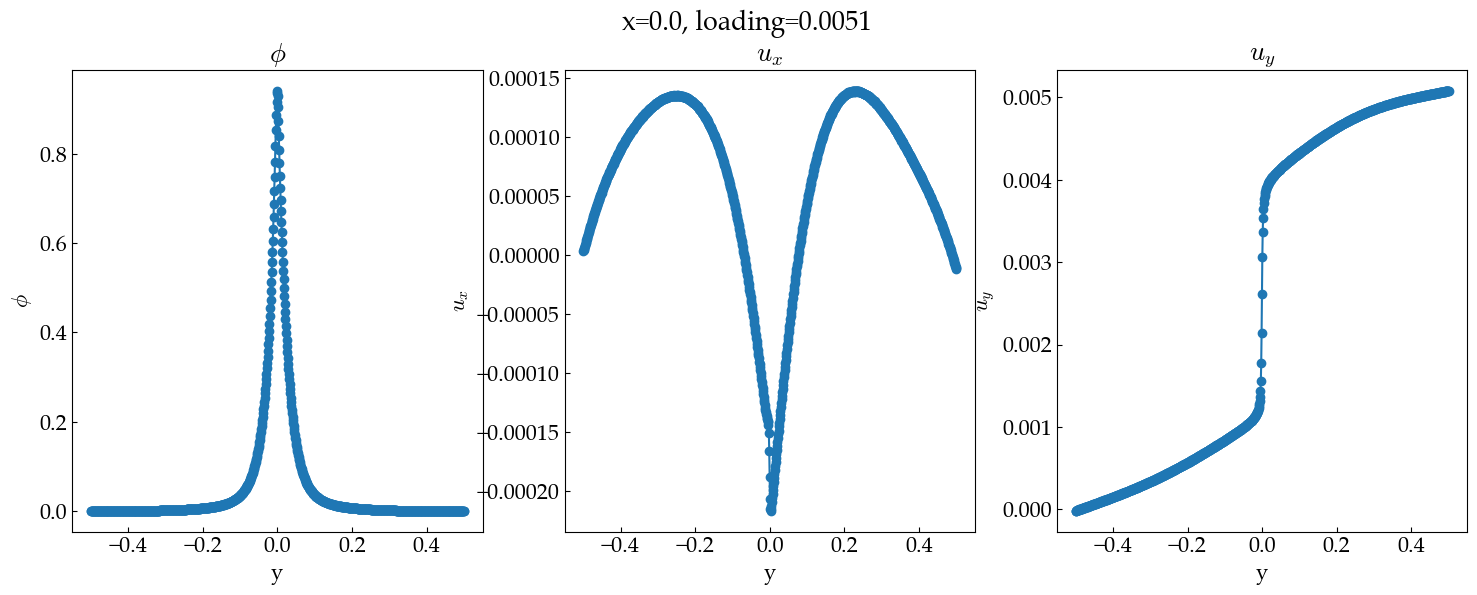

In [7]:
ys = jnp.linspace(-0.5, 0.5, 1000)
xs = jnp.ones_like(ys) * (-0.)
slice_mesh = jnp.stack([xs, ys], axis=1)
tic = 0.5
t = jnp.ones_like(slice_mesh[:, 0]) * tic
t = t.reshape(-1, 1)
phi, disp = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, slice_mesh, t)
disp_loading = cfg.loading(tic)

# fig, ax = plt.subplots(figsize=(6, 4))
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax = axes[0]
ax.plot(ys, phi, label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$\phi$",
    title=r"$\phi$",
)

ax = axes[1]
ax.plot(ys, disp[:, 0], label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$u_x$",
    title=r"$u_x$",
)

ax = axes[2]
ax.plot(ys, disp[:, 1], label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$u_y$",
    title=r"$u_y$",
)


fig.suptitle(f"x=0.0, loading={disp_loading:.4f}")

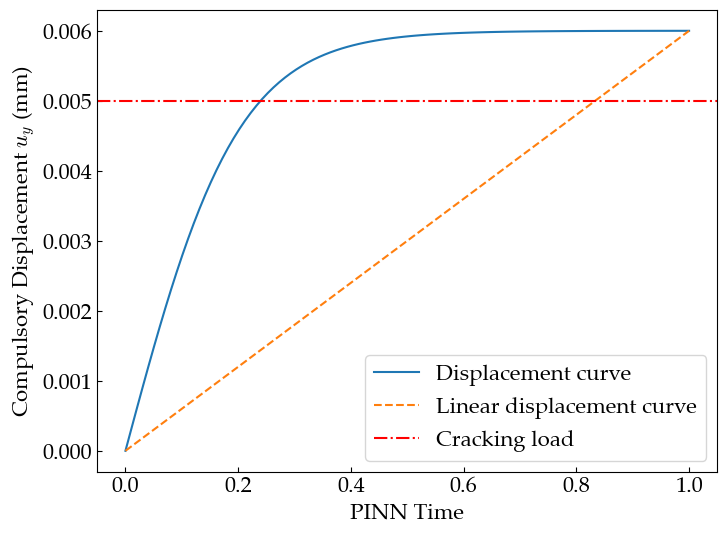

In [8]:
%matplotlib inline

t = jnp.linspace(0, 1, 100)
# load = cfg.loading(t)



def loading_fn(t, alpha=5, ):
    # return cls.UR * t
    return 0.006 / jax.nn.tanh(alpha) * jax.nn.tanh(alpha* t)
    # return 0.006 / jnp.log(alpha+1) * jnp.log(alpha*t+1)
    # return jnp.where(t<0.1, 0.005 / 0.1*t, (0.006-0.005) / 0.9*(t - 0.1) + 0.005)
load = loading_fn(t)
load_linear = t * 0.006
cracking_load = 0.005

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, load, label="Displacement curve",)
ax.plot(t, load_linear, label="Linear displacement curve", linestyle="--")
ax.axhline(cracking_load, color="red", linestyle="-.", label="Cracking load")
ax.set(xlabel="PINN Time", ylabel="Compulsory Displacement $u_y$ (mm)")
ax.legend()

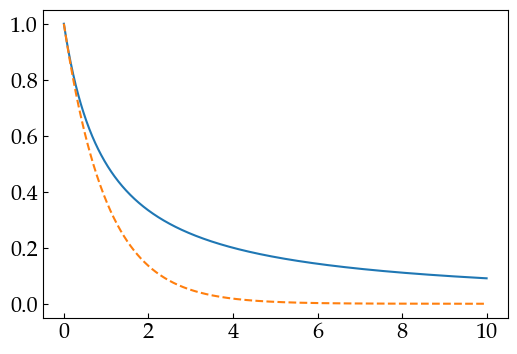

In [9]:
%matplotlib inline
x = jnp.linspace(0, 10, 1000)
y1 = 1 / (1 + x)
y2 = jnp.exp(-x)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y1, label="1 / (1 + x)",)
ax.plot(x, y2, label="exp(-x)", linestyle="--")

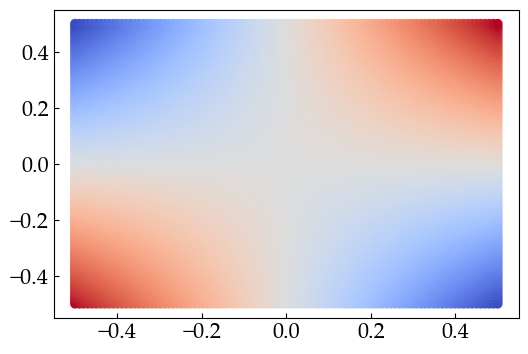

In [10]:
xs = jnp.linspace(-0.5, 0.5, 100)
ys = jnp.linspace(-0.5, 0.5, 100)
xs, ys = jnp.meshgrid(xs, ys)
mesh = jnp.stack([xs, ys], axis=-1)
mesh = mesh.reshape(-1, 2)
xs, ys = jnp.split(mesh, 2, axis=-1)
phi = xs * ys

# phi = jnp.exp(-jnp.abs(ys) / 0.015) * jax.nn.sigmoid(-xs * 100)
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(xs, ys, c=phi, cmap="coolwarm")